In [1]:
%conda install torchtext -y -c pytorch

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::seaborn-base==0.11.1=pyhd8ed1ab_1
  - conda-forge/noarch::nbclassic==0.2.6=pyhd8ed1ab_0
  - defaults/linux-64::numpy==1.19.2=py36h54aff64_0
  - conda-forge/linux-64::numexpr==2.7.2=py36h284efc9_0
  - conda-forge/linux-64::statsmodels==0.12.2=py36h92226af_0
  - conda-forge/linux-64::matplotlib==3.3.4=py36h5fab9bb_0
  - conda-forge/linux-64::h5py==3.1.0=nompi_py36hc1bc4f5_100
  - conda-forge/linux-64::scipy==1.5.3=py36h9e8f40b_0
  - conda-forge/noarch::jupyterlab==3.0.9=pyhd8ed1ab_0
  - conda-forge/noarch::python-language-server==0.36.2=pyhd8ed1ab_0
  - conda-forge/noarch::jupyterlab_server==2.3.0=pyhd8ed1ab_0
  - conda-forge/linux-64::pytables==3.6.1=py36hb7ec5aa_3
  - conda-forge/linux-64::pandas==1.1.5=py36h284efc9_0
  - conda-forge/linux-64::astropy==4.1=py36ha112f06_2
  - conda-forge/noarch::pyls-black==0.4.6=

In [6]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
from ast import literal_eval

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import sagemaker
import boto3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
COLAB = False # Edit this if needed
AWS = True
MAX_LENGTH = 10 # For our purposes (last 10 words) keep at 10.

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')
    CHECKPOINT_PATH = '/content/drive/MyDrive/s2s_checkpoint.tar' # Edit if needed
    path = '/content/drive/MyDrive/Cleaned_Summaries_And_Bills.csv' # Edit if needed
elif AWS:
    sagemaker_session = sagemaker.Session()
    role = sagemaker.get_execution_role()
    bucket = 'capp-20235'
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket=bucket, Key='Minimum_Length_Sample.csv')
    CHECKPOINT_PATH = 's2s_checkpoint.tar'
else:
    CHECKPOINT_PATH = 's2s_checkpoint.tar' # Edit if needed
    path = 'Cleaned_Summaries_And_Bills.csv' # Edit if needed

# Read in the dataframe 
if AWS:
    df = pd.read_csv(response['Body'], converters={'summary_clean': literal_eval, 'bill_clean': literal_eval})
else:
    df = pd.read_csv(path, converters={'summary_clean': literal_eval, 'bill_clean': literal_eval})
# Keep only the last 10 words of the summaries and bills
df['summary_clean'] = df['summary_clean'].apply(lambda x: x[-10:])
df['bill_clean'] = df['bill_clean'].apply(lambda x: x[-10:])

In [10]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "<sos>", 1: "<eos>"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [11]:
def read_langs(df):
    pairs = []
    for row in df[['bill_clean', 'summary_clean']].itertuples():
        bill = ' '.join(row[1][1:-1])
        summary = ' '.join(row[2][1:-1])
        pair = bill, summary
        pairs.append(pair)
    return pairs

In [12]:
def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

In [13]:
def prepare_data(df):
    input_lang = Lang('bill')
    output_lang = Lang('summary')
    pairs = read_langs(df)
    print(f"Read {len(pairs)} bill pairs")
    pairs = filter_pairs(pairs)
    print(f"Trimmed to {len(pairs)} bill pairs")
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [14]:
input_lang, output_lang, pairs = prepare_data(df)
print(random.choice(pairs))

Read 455 bill pairs
Trimmed to 455 bill pairs
Counting words...
Counted words:
bill 807
summary 1048
('coverage of non-invasive prenatal genetic screeningsection ####; .', 'noninvasive prenatal genetic screening for pregnant women .')


In [15]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [16]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [17]:
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensor_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensors_from_pair(pair):
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    target_tensor = tensor_from_sentence(output_lang, pair[1])
    return input_tensor, target_tensor

In [18]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.init_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [19]:
import time
import math


def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [20]:
def train_iters(encoder, decoder, n_iters, encoder_optimizer=None, decoder_optimizer=None, print_every=1000, plot_every=100, save_every=None, learning_rate=0.0001):
    encoder.train()
    decoder.train()
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    if not encoder_optimizer:
        encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    if not decoder_optimizer:
        decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensors_from_pair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        
        if save_every and iter % save_every == 0:
            torch.save(
                {
                    'iteration': iter,
                    'encoder_state_dict': encoder.state_dict(),
                    'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
                    'decoder_state_dict': decoder.state_dict(),
                    'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
                    'loss': loss
                },
                CHECKPOINT_PATH
            )

    show_plot(plot_losses)

In [21]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline


def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Matplotlib is building the font cache; this may take a moment.


In [22]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        input_tensor = tensor_from_sentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.init_hidden()

        for ei in range(input_length):
            _, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<eos>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [23]:
def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [25]:
# These things all have to be the same was when the model was originally created
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)
encoder_optimizer = optim.SGD(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=0.001)

# Load the checkpointed model
# checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device(device))
# encoder.load_state_dict(checkpoint['encoder_state_dict'])
# encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
# decoder.load_state_dict(checkpoint['decoder_state_dict'])
# decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
# iteration = checkpoint['iteration']
# loss = checkpoint['loss']

> fund had such amendments not been enacted .
= america's main street act this bill allows&nbsp; .
< the the the the the the . . . .

28m 23s (- 255m 27s) (10000 10%) 5.1740
60m 13s (- 240m 52s) (20000 20%) 4.4281
92m 53s (- 216m 45s) (30000 30%) 3.5275
123m 9s (- 184m 43s) (40000 40%) 2.5835
153m 16s (- 153m 16s) (50000 50%) 1.7871
183m 26s (- 122m 17s) (60000 60%) 1.1376
217m 50s (- 93m 21s) (70000 70%) 0.7670
248m 2s (- 62m 0s) (80000 80%) 0.5728
278m 13s (- 30m 54s) (90000 90%) 0.4518
308m 23s (- 0m 0s) (100000 100%) 0.3837
> of business of each borrower or grantee .
= impact of certain relief programs on jobs .
< impact of certain relief programs on jobs . . .

> u .s . customs and border protection .
= customs and border protection a deportation hearing .
< customs and border protection a deportation hearing . . .

> preceding sentence shall remain available until expended .
= unemployment claims, transmitting information, and addressing fraud .
< unemployment claims, transmittin

<Figure size 432x288 with 0 Axes>

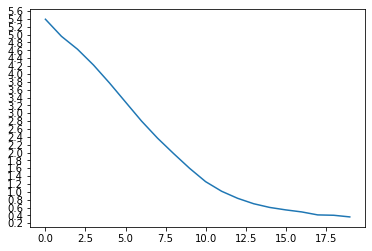

In [28]:
# Evaluate the model on a random bill
evaluate_randomly(encoder, decoder, 1)
# Train the model. This will overwrite the checkpointed model!
# This took me 20-25 minutes to run.
train_iters(encoder, decoder, encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer, n_iters=100000, print_every=10000, plot_every=5000, save_every=1000)
# Evaluate the model on 10 random bills
evaluate_randomly(encoder, decoder, 10)

In [29]:
evaluate_randomly(encoder, decoder, 1)

> status for irida kakhtiranova of such act .
= provides for the relief of irida kakhtiranova .
< provides for the relief of irida kakhtiranova . . .

